In [1]:
import numpy as np
from numpy import random
import pandas as pd
import scipy as sp
from prosstt import simulation as sim
from prosstt import tree
from prosstt.tree import Tree

import matplotlib.pyplot as plt

In [2]:
def save_files(job_id, save_dir, X, labs, brns, scalings, uMs, Hs, gene_scale, alpha, beta):
    # make the data more presentable by adding gene and cell names
    cell_names = ["cell_" + str(i) for i in range(X.shape[0])]
    gene_names = ["gene_" + str(i) for i in range(X.shape[1])]

    pdX = pd.DataFrame(X, columns=gene_names, index=cell_names).astype(int)
    pdCells = pd.DataFrame({"pseudotime": labs, "branches": brns, "scalings": scalings}, index=cell_names,
                           columns=["pseudotime", "branches", "scalings"])
    pdGenes = pd.DataFrame({"alpha": alpha, "beta": beta, "genescale": gene_scale}, index=gene_names,
                           columns=["alpha", "beta", "genescale"])

    pdX.to_csv(save_dir + "/" + job_id + "_simulation.txt", sep="\t")
    pdCells.to_csv(save_dir + "/" + job_id + "_cellparams.txt", sep="\t")
    pdGenes.to_csv(save_dir + "/" + job_id + "_geneparams.txt", sep="\t")

    num_branches = len(uMs)
    for i in range(num_branches):
        np.savetxt(fname=save_dir + "/" + job_id + "_ums" + str(i) + ".txt", X=uMs[i])
        np.savetxt(fname=save_dir + "/" + job_id + "_hs" + str(i) + ".txt", X=Hs[i])


def save_params(job_id, save_dir, G, br_lengths, br_compl, rseed, topology):
    paramfile = save_dir + "/" + job_id + "_params.txt"
    with open(paramfile, 'w') as out:
        out.write("Genes: " + str(G) + "\n")
        out.write("pseudotimes: " + str(br_lengths) + "\n")
        out.write("topology: " + str(topology) + "\n")
        out.write("#modules: " + str(br_compl) + "\n")
        out.write("random seed: " + str(rseed))

read the parameters of a previous simulation and initialize a new tree with this information

In [3]:
loc = "/data/niko/repeat/benchmark1/test38/test38_"

G = 758
pseudotimes = {0:50, 1:50, 2:50}
topology = [[0, 1], [0, 2]]
gene_params = pd.read_csv(loc + "geneparams.txt", sep="\t", index_col=0)
alpha = np.array(gene_params["alpha"])
beta = np.array(gene_params["beta"])
base_exp = np.array(gene_params["genescale"])

uMs = [np.zeros((pseudotimes[i], G)) for i in range(3)]
Ms = {i:np.zeros((pseudotimes[i], G)) for i in range(3)}
for i in range(3):
    uMs[i] = np.loadtxt(loc + "ums" + str(i) + ".txt")
    Ms[i] = np.exp(uMs[i]) * base_exp

t = tree.Tree(topology, pseudotimes, 3, 1, 10, G)
t.add_genes(Ms)

In [4]:
X, labs, brns, scalings = sim.sample_density(t, 300, alpha=alpha, beta=beta, scale_v=0.8)

diffusion map of the resampled simulation

In [5]:
import anndata as ad
from scanpy.api.tl import diffmap

data = ad.AnnData(X)
diffmap(adata=data)
dm = data.obsm["X_diffmap"]

read the expression matrix of the original simulation and calculate its diffusion map as well

In [6]:
import pandas as pd

expr_matrix = pd.read_csv(loc + "simulation.txt", sep="\t", index_col=0)
X = np.array(expr_matrix)
data = ad.AnnData(X)
diffmap(adata=data)
dm_og = data.obsm["X_diffmap"]

# read the branch assignments as well
cell_params = pd.read_csv(loc + "cellparams.txt", sep="\t", index_col=0)

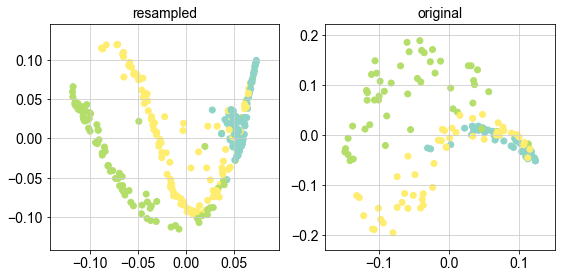

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
# make sure to use viridis as the default color map
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'

# translate the branch assignment of each cell to a number
br_names, indices = np.unique(brns, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(w=9, h=4)
ax[0].scatter(dm[:, 0], dm[:, 3], c=indices, cmap="Set3")
ax[0].set_title("resampled")

br_names, indices = np.unique(cell_params["branches"], return_inverse=True)
# dark blue is the beginning, yellow is the end
ax[1].scatter(dm_og[:, 0], dm_og[:, 3], c=indices, cmap="Set3")
ax[1].set_title("original")

In [8]:
# job_id = "single"
# save_dir = "/some/output/directory/"
# save_params(job_id, save_dir, G, pseudotimes, 10, "none", topology)
# save_files(job_id, save_dir, X, labs, brns, scalings, uMs, uMs, base_exp, alpha, beta) # replace with real hs from simulation
# scalefile = save_dir + "/" + job_id + "_scalings.txt"
# np.savetxt(scalefile, scalings)